In [2]:
import scipy, cv2
import numpy as np
import matplotlib.pyplot as plt

def rgb_to_gray(img):
    if len(img.shape) == 3:
        gray_image = np.mean(img, axis=2).astype(np.float64)
    else:
        gray_image = img
    return gray_image
def gaussian_blur_kernel_2d(kernel_size=3,sigma=1):
    kernel=np.zeros((kernel_size,kernel_size))
    r = kernel_size//2
    for x in range(-r,r+1):
        for y in range(-r,r+1):
            kernel[x+r,y+r] = 1/(2*np.pi*sigma**2)*np.exp(-1/(2*sigma**2)*(x**2+y**2))
    kernel = kernel / np.sum(kernel)
    return kernel
def convolve_2d(X,K):
    height,width = K.shape
    X = np.flip(np.flip(X, axis=0), axis=1)
    Y = np.zeros((X.shape[0]-height+1,X.shape[1]-width+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i][j]=(X[i:i+height, j:j+height]*K).sum()
    return np.flip(np.flip(Y, axis=0), axis=1)
def gradient_x(img):
    # convert img to grayscale
    # should we use int type to calclate gradient?
    # should we conduct some pre-processing to remove noise? which kernel should we pply?
    # which kernel should we choose to calculate gradient_x?
    # TODO
    gray_image = rgb_to_gray(img)
    filtered_image = scipy.ndimage.gaussian_filter(gray_image, sigma = 1, mode = 'reflect')
    return scipy.ndimage.sobel(filtered_image, axis = 0, mode = 'reflect')

def gradient_y(img):
    # TODO
    gray_image = rgb_to_gray(img)
    filtered_image = scipy.ndimage.gaussian_filter(gray_image, sigma = 1, mode = 'reflect')
    return scipy.ndimage.sobel(filtered_image, axis = 1, mode = 'reflect')

def harris_response(img, alpha=0.05, win_size=3):
    # In this function you are going to claculate harris response R.
    # Please refer to 04_Feature_Detection.pdf page 29 for details. 
    # You have to discover how to calculate det(M) and trace(M), and
    # remember to smooth the gradients. 
    # Avoid using too much "for" loops to speed up.
    # TODO
    win_size = win_size // 2
    grad_x = gradient_x(img)
    grad_y = gradient_y(img)
    sigma = win_size / 7
    kernel = gaussian_blur_kernel_2d(win_size, sigma)
    A = grad_x * grad_x
    B = grad_x * grad_y
    C = grad_y * grad_y
    R = np.zeros_like(A)
    for i in range(win_size, img.shape[0] - win_size):
        for j in range(win_size, img.shape[1] - win_size):
            windows_A = np.sum(A[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            windows_B = np.sum(B[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            windows_C = np.sum(C[i - win_size:i + win_size + 1, j - win_size:j + win_size + 1] * kernel)
            det_R = windows_A * windows_C - windows_B * windows_B
            tr_R = windows_A + windows_C
            windows_R = det_R - alpha * tr_R**2
            R[i, j] = windows_R
    return R

def corner_selection(R, th=0.01, min_dist=3):
    # non-maximal suppression for R to get R_selection and transform selected corners to list of tuples
    # hint: 
    #   use ndimage.maximum_filter()  to achieve non-maximum suppression
    #   set those which aren’t **local maximum** to zero.
    # TODO
    width, height = R.shape
    threshold = th * np.max(R)
    condition_matrix = (R > threshold).astype(np.uint8)
    pix = []
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if condition_matrix[i, j]:
                window = R[np.clip(i-min_dist//2,0,width-1):np.clip(i+min_dist//2,0,width-1), np.clip(j-min_dist//2,0,height-1):np.clip(j+min_dist//2,0,height-1)]
                if R[i,j]-1e-6<np.max(window) < R[i,j] + 1e-6:
                    pix.append((i,j))
    return list(pix)

C:\Users\远垂\AppData\Local\Temp\ipykernel_18368\505918464.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(i[1],i[0],'ro',markersize=1,color='yellow')


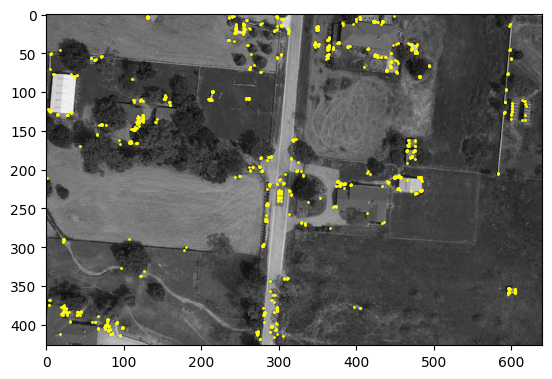

In [3]:
file_path = './Problem_Set_2/Problem2Images/1_2.jpg'
image = cv2.imread(file_path)
R = harris_response(image,0.05,3)
target = corner_selection(R,0.007,2)
output = np.zeros_like(R)
image = rgb_to_gray(image)
image = rgb_to_gray(image)
for i in target:
    # image[i[0],i[1]]=255
    plt.plot(i[1],i[0],'ro',markersize=1,color='yellow')
plt.imshow(image,cmap='gray')

plt.show()


C:\Users\远垂\AppData\Local\Temp\ipykernel_18368\1709136652.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(j,i,'ro',markersize=0.5,color='yellow')


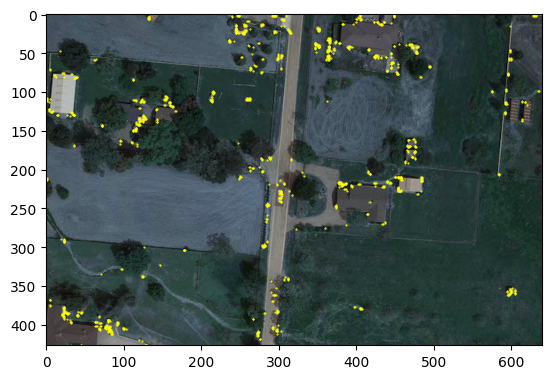

In [4]:
import cv2
import numpy as np

img = cv2.imread(file_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2, 9, 0.05)
target = dst>0.01*dst.max()
for i in range(target.shape[0]):
    for j in range(target.shape[1]):
        if target[i,j]: 
    # image[i[0],i[1]]=255
            plt.plot(j,i,'ro',markersize=0.5,color='yellow')
#img[dst>0.01 * dst.max()] = [0, 0, 255]

plt.imshow(img)
plt.show()


In [5]:
file_path = './Problem_Set_2/Problem2Images/3_1.jpg'
file_path_2 = './Problem_Set_2/Problem2Images/3_2.jpg'
image = cv2.imread(file_path)
image_2 = cv2.imread(file_path_2)
image = rgb_to_gray(image)
image_2 = rgb_to_gray(image_2)
corners_1 = corner_selection(harris_response(image,0.05,3),0.01,3)
corners_2 = corner_selection(harris_response(image_2,0.05,3),0.01,3)

In [6]:
def histogram_of_gradients(img, pix):
    # no template for coding, please implement by yourself.
    # You can refer to implementations on Github or other websites
    # Hint: 
    #   1. grad_x & grad_y
    #   2. grad_dir by arctan function
    #   3. for each interest point, choose m*m blocks with each consists of m*m pixels
    #   4. I divide the region into n directions (maybe 8).
    #   5. For each blocks, calculate the number of derivatives in those directions and normalize the Histogram. 
    #   6. After that, select the prominent gradient and take it as principle orientation.
    #   7. Then rotate it’s neighbor to fit principle orientation and calculate the histogram again. 
    # TODO
    WIDTH,HEIGHT = img.shape
    block_size = 4  # 块大小
    num_bins = 8 # 方向直方图的箱数
    grad_x = gradient_x(img)
    grad_y = gradient_y(img)
    grad_magnitude = np.sqrt(grad_x**2,grad_y**2)
    grad_direction = np.arctan2(grad_y,grad_x)*180.0/np.pi + 180.0
    features = []
    for cornel in pix:
        cornel_x, cornel_y = cornel
        # 选角点周围的区域
        # 先算出主方向
        temp_feature = [0 for i in range(num_bins)]
        for i in range(cornel_x - block_size**2//2 + 1, cornel_x + block_size**2//2 + 1):
            for j in range(cornel_y - block_size**2//2 + 1, cornel_y + block_size**2//2 + 1):
                    temp_feature[int(grad_direction[np.clip(i,0,WIDTH-1),np.clip(j,0,HEIGHT-1)]*num_bins/360)]+=grad_magnitude[np.clip(i,0,WIDTH-1),int(np.clip(j,0,HEIGHT-1))]
        orientation = np.argmax(temp_feature)*2*np.pi/num_bins
        change = np.array([[np.cos(orientation),-np.sin(orientation)],[np.sin(orientation),np.cos(orientation)]])
        feature = []
        #print(change)
        # 从右上角往下遍历, 旋转
        for index_x in range(-block_size//2,block_size//2):
            for index_y in range(-block_size//2,block_size//2):
                temp_feature = [0 for i in range(num_bins)]
                for i in range(cornel_x + index_x * block_size + 1, cornel_x + (index_x + 1) * block_size + 1):
                    for j in range(cornel_y + index_y * block_size + 1, cornel_y + (index_y + 1) * block_size + 1):
                        new_point = np.array(change@[i,j],dtype=np.uint8)
                        x,y=new_point
                        p=int(grad_direction[np.clip(x,0,WIDTH-1),np.clip(y,0,HEIGHT-1)]*num_bins/360)
                        if p==num_bins:
                             p=0
                        temp_feature[p]+= \
                        grad_magnitude[np.clip(x,0,WIDTH-1),np.clip(y,0,HEIGHT-1)]
                
                feature+=temp_feature
                #print(temp_feature)
        # 归一化
        feature = feature / np.sum(feature)
        features.append(feature)
    return features

In [7]:
features_1 = histogram_of_gradients(image, corners_1)
features_2 = histogram_of_gradients(image_2, corners_2)

In [8]:
features_1=np.array(features_1)
features_2=np.array(features_2)

In [14]:
THRESHOLD = 0.08
pix_1 = []
pix_2 = []

for i, feature_1 in enumerate(features_1):
    # temp_point = None
    # temp_bias = float('inf')
    # for j, feature_2 in enumerate(features_2):
    #     bias = np.sqrt(np.sum((feature_1-feature_2)**2))
    #     if bias < temp_bias:
    #         temp_bias = bias
    #         temp_point = j
    # if temp_bias > THRESHOLD:
    #     continue
    # temp_point_2 = None
    # temp_bias_2 = float('inf')
    # for k, feature in enumerate(features_1):
    #     bias = np.sqrt(np.sum((feature-features_2[temp_point])**2))
    #     if bias<temp_bias_2:
    #         temp_bias_2 = bias
    #         temp_point_2 = k
    # if temp_point_2 == i:
    #     pix_1.append(corners_1[i])
    #     pix_2.append(corners_2[temp_point])
    temp_bias = []
    temp_point = []
    for j, feature_2 in enumerate(features_2):
        bias = np.sqrt(np.sum((feature_1-feature_2)**2))
        #print(bias)
        if bias < THRESHOLD:
            temp_point.append(corners_2[j])
            temp_bias.append(bias)
    if len(temp_point):
        pix_1.append(corners_1[i])
        pix_2.append(temp_point[np.argmin(temp_bias)])
print(pix_1)
print(len(pix_1))
print(pix_2)


[(75, 308), (96, 276), (97, 276), (103, 272), (107, 40), (107, 357), (108, 217), (110, 219), (110, 224), (110, 231), (111, 215), (111, 218), (111, 221), (111, 224), (111, 230), (112, 45), (112, 204), (112, 205), (112, 207), (112, 208), (112, 215), (112, 217), (112, 218), (112, 220), (112, 221), (112, 223), (113, 156), (113, 204), (113, 207), (113, 217), (113, 220), (114, 203), (114, 204), (114, 214), (114, 244), (114, 245), (114, 246), (114, 247), (115, 213), (115, 243), (115, 244), (116, 207), (116, 213), (116, 218), (117, 192), (117, 207), (117, 218), (117, 244), (117, 246), (118, 192), (118, 193), (118, 204), (118, 205), (118, 245), (119, 188), (119, 192), (119, 195), (119, 196), (119, 203), (119, 204), (119, 205), (122, 190), (122, 191), (124, 178), (124, 182), (125, 177), (125, 178), (127, 179), (127, 183), (127, 184), (128, 178), (128, 179), (132, 163), (132, 172), (133, 162), (133, 163), (135, 212), (136, 211), (136, 212), (136, 215), (137, 181), (137, 182), (137, 183), (137, 21

C:\Users\远垂\AppData\Local\Temp\ipykernel_18368\3844942438.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
C:\Users\远垂\AppData\Local\Temp\ipykernel_18368\3844942438.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')


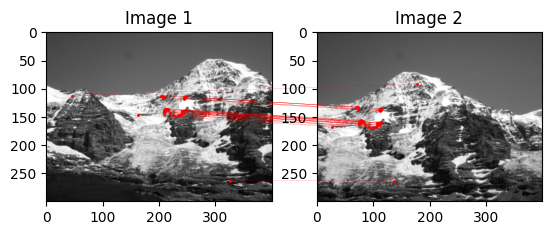

In [13]:
from matplotlib.patches import ConnectionPatch
import matplotlib

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image, cmap='gray')
ax1.set_title('Image 1')
# 在第二个子图上显示第二幅图像
ax2.imshow(image_2, cmap='gray')
ax2.set_title('Image 2')


for i in range(len(pix_1)):
    ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
    ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')
    con = ConnectionPatch(xyA=(pix_1[i][1],pix_1[i][0]), xyB=(pix_2[i][1],pix_2[i][0]), linewidth=0.1, axesA= ax1,axesB=ax2,coordsA='data',
                       coordsB='data',color="red")
    ax2.add_artist(con)


plt.show()



In [15]:
from random import sample
def compute_homography(pixels_1, pixels_2):
    # compute the best-fit homography using the Singular Value Decomposition (SVD)
    # homography matrix is a (3,3) matrix consisting rotation, translation and projection information.
    # consider how to form matrix A for U, S, V = np.linalg.svd((np.transpose(A)).dot(A))
    # homo_matrix = np.reshape(V[np.argmin(S)], (3, 3))
    # TODO
    A = []
    for p1, p2 in zip(pixels_1, pixels_2):
        x1, y1 = p1
        x2, y2 = p2
        A.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2, -x2])
        A.append([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2, -y2])
    A = np.array(A)
    # 使用SVD分解
    U, S, V = np.linalg.svd((np.transpose(A)).dot(A))
    homo_matrix = np.reshape(V[np.argmin(S)], (3, 3))
    return homo_matrix



In [16]:
def align_pair(pixels_1, pixels_2):
    
    # utilize \verb|homo_coordinates| for homogeneous pixels
    # and \verb|compute_homography| to calulate homo_matrix
    # implement RANSAC to compute the optimal alignment.
    # you can refer to implementations online.
    num_iterations = 100000 # Number of RANSAC iterations
    inlier_threshold = 5.0  # Threshold for considering a point as an inlier
    num_picked = 4
    best_inliers = []  # Best set of inliers
    best_est_homo = None  # Best estimated homography matrix

    for _ in range(num_iterations):
        # Randomly sample 4 point correspondences
        sample_indices = sample(range(len(pixels_1)), num_picked)
        sampled_pixels_1 = [pixels_1[i] for i in sample_indices]
        sampled_pixels_2 = [pixels_2[i] for i in sample_indices]

        # Calculate homography matrix using the sampled points
        est_homo = compute_homography(sampled_pixels_1, sampled_pixels_2)
        # Transform all pixels from image 1 using the estimated homography
        homo_coordinates_1 = np.array([pixels_1[i] + tuple([1]) for i in range(len(pixels_1))])
        transformed_pixels = np.dot(est_homo, homo_coordinates_1.T).T
    
        transformed_pixels = transformed_pixels[:, :2] / transformed_pixels[:, 2, None]+1e-6
        
        # Calculate the Euclidean distance between the transformed pixels and image 2 pixels
        distances = np.linalg.norm(transformed_pixels - pixels_2, axis=1)

        # Count the number of inliers based on the threshold
        inliers = np.where(distances < inlier_threshold)[0]
        
        # Update the best set of inliers and homography matrix if this is the best so far
        if len(inliers) > len(best_inliers):
            print(len(inliers))
            best_inliers = inliers
            best_est_homo = est_homo

    return best_est_homo
test = align_pair(pix_1,pix_2)

9
135


In [102]:
def stitch_blend(img_1, img_2, est_homo):
    # hint: 
    # First, project four corner pixels with estimated homo-matrix
    # and converting them back to Cartesian coordinates after normalization.
    # Together with four corner pixels of the other image, we can get the size of new image plane.
    # Then, remap both image to new image plane and blend two images using Alpha Blending.
    # TODO
    W, H= img_1.shape[:2]
    corners = np.array([[0, 0, 1], [W, 0, 1], [W, H, 1], [0, H, 1]])
    projected_corners = np.dot(est_homo, corners.T).T
    projected_corners /= projected_corners[:, 2, np.newaxis]
    min_x = np.min(projected_corners[:,1])
    max_x = np.max(projected_corners[:,1])
    min_y = np.min(projected_corners[:,0])
    max_y = np.max(projected_corners[:,0])

    width,height = img_2.shape
    
    alpha = 0.45
    if min_x < 0:
        height -= min_x
    if min_y < 0:
        width +=min_y
        
    print(min_x,min_y)
    width = max(width,max_y)
    height = max(height,max_x)
    est_img = np.zeros((int(width),int(height)))
    for i in range(W):
        for j in range(H):
            x,y=i,j
            if min_x>0:
                y = int(y+min_x)
            if min_y>0:
                x = int(x+min_y)
            est_img[x,y]=img_1[i,j]*alpha
    for i in range(img_2.shape[0]-1):
        for j in range(img_2.shape[1]-1):
            x,y=i,j
            if min_x<0:
                y-=min_x
            if min_y<0:
                x-=min_y
            est_img[int(x),int(y)]+=(1-alpha)*img_2[i,j]
    return est_img

-134.00000069839615 20.99999991416917


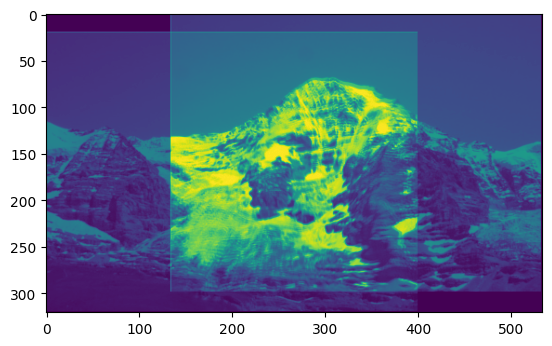

In [103]:
blend = stitch_blend(image,image_2,test)
plt.imshow(blend)
plt.show()

[[ 7.37209778e-03  4.96910878e-12  1.54814053e-01]
 [-5.62488438e-12  7.37209780e-03 -9.87861106e-01]
 [-1.16158710e-16 -2.65087431e-17  7.37209778e-03]]
[21, -133]
[21, -132]
[21, -131]
[21, -130]
[21, -129]
[21, -128]
[21, -127]
[21, -126]
[21, -125]
[21, -124]
[21, -123]
[21, -122]
[21, -121]
[21, -120]
[21, -119]
[21, -118]
[21, -117]
[21, -116]
[21, -115]
[21, -114]
[21, -113]
[21, -112]
[21, -111]
[21, -110]
[21, -109]
[21, -108]
[21, -107]
[21, -106]
[21, -105]
[21, -104]
[21, -103]
[21, -102]
[21, -101]
[21, -100]
[21, -99]
[21, -98]
[21, -97]
[21, -96]
[21, -95]
[21, -94]
[21, -93]
[21, -92]
[21, -91]
[21, -90]
[21, -89]
[21, -88]
[21, -87]
[21, -86]
[21, -85]
[21, -84]
[21, -83]
[21, -82]
[21, -81]
[21, -80]
[21, -79]
[21, -78]
[21, -77]
[21, -76]
[21, -75]
[21, -74]
[21, -73]
[21, -72]
[21, -71]
[21, -70]
[21, -69]
[21, -68]
[21, -67]
[21, -66]
[21, -65]
[21, -64]
[21, -63]
[21, -62]
[21, -61]
[21, -60]
[21, -59]
[21, -58]
[21, -57]
[21, -56]
[21, -55]
[21, -54]
[21, -53]
[2

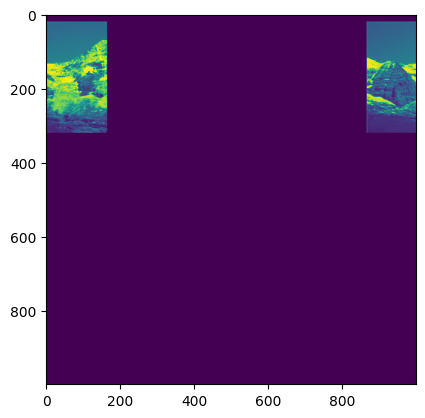

In [17]:
height, width = image.shape
#test= test/test[2][2]
print(test)
new_pic = np.zeros((1000,1000))
for i in range(width-1):
    for j in range(height-1):
       try:
              homo = [i,j,1]
              new = test@homo
              
              new = new/new[2]+1e-6
              new = [int(new[0]),int(new[1])]
              print(new)
              new_pic[new[0],new[1]] = \
              image[i,j]
       except:
            continue
plt.imshow(new_pic)
plt.show()

C:\Users\远垂\AppData\Local\Temp\ipykernel_23256\3844942438.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax1.plot(pix_1[i][1],pix_1[i][0],'ro',markersize=1,color='red')
C:\Users\远垂\AppData\Local\Temp\ipykernel_23256\3844942438.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(pix_2[i][1],pix_2[i][0],'ro',markersize=1,color='red')


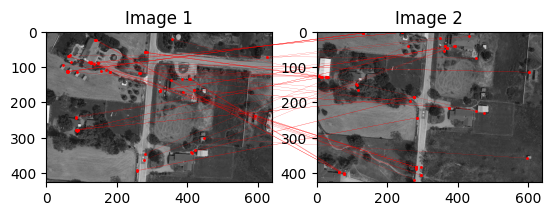